# Imports and Configs

In [1]:
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import (
    VotingClassifier,
    RandomForestClassifier,
    GradientBoostingClassifier,
    HistGradientBoostingClassifier
)
from optuna.samplers import TPESampler
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import pickle
import shutil
import optuna
import os

sns.set_style('whitegrid')
warnings.filterwarnings('ignore')

In [2]:
SEED = 27
N_FOLDS = 5
TARGET = 'Target'

# Loading and Processing the Datasets

In [3]:
train = pd.read_csv('/kaggle/input/playground-series-s4e6/train.csv', index_col='id')
test = pd.read_csv('/kaggle/input/playground-series-s4e6/test.csv', index_col='id')

train.shape, test.shape

((76518, 37), (51012, 36))

In [4]:
# Reference: https://www.kaggle.com/code/ambrosm/pss4e6-eda-which-makes-sense
cat_features = [
    'Marital status',
    'Application mode',
    'Course',
    'Previous qualification',
    'Nacionality',
    "Mother's qualification",
    "Father's qualification",
    "Mother's occupation",
    "Father's occupation"
]


for col in cat_features:
    train[col] = train[col].astype('category')
    test[col] = test[col].astype('category')

In [5]:
X = train.drop(TARGET, axis=1)
y = train[TARGET]

In [6]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Defining Training and Cross Validation Functions

In [7]:
class Trainer:
    def __init__(self, model, n_folds=N_FOLDS):
        self.model = model
        self.n_folds = n_folds

    def fit(self, X, y):
        print(f'Training {self.model.__class__.__name__}')

        rskf = StratifiedKFold(n_splits=self.n_folds, random_state=SEED, shuffle=True)

        accs = []
        aucs = []
        oof_pred_probs = np.zeros((X.shape[0], len(np.unique(y))))
        oof_preds = np.zeros(X.shape[0])
        for fold_idx, (train_idx, val_idx) in enumerate(rskf.split(X, y)):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]

            self.model.fit(X_train, y_train)

            y_pred_probs = self.model.predict_proba(X_val)
            y_pred = np.argmax(y_pred_probs, axis=1)

            oof_pred_probs[val_idx] = y_pred_probs
            oof_preds[val_idx] = y_pred

            acc = accuracy_score(y_val, y_pred)
            auc = roc_auc_score(y_val, y_pred_probs, multi_class='ovo')
            accs.append(acc)
            aucs.append(auc)

            print(f'--- Fold {fold_idx + 1} - Accuracy: {acc:.6f}, AUC: {auc:.6f}')

        print(f'\n------ Accuracy: {np.mean(accs):.6f} ± {np.std(accs):.6f}')
        print(f'------ AUC:      {np.mean(aucs):.6f} ± {np.std(aucs):.6f}\n\n')

        return self.model, oof_pred_probs, oof_preds, accs, aucs

In [8]:
xgb_params = {
    'n_jobs': -1,
    'max_bin': 86,
    'verbosity': 0,
    'max_depth': 5,
    'max_leaves': 64,
    'booster': 'gbtree',
    'n_estimators': 1539,
    'random_state': SEED,
    'enable_categorical': True,
    'gamma': 0.9069384135972282,
    'reg_alpha': 9.076826031603096,
    'subsample': 0.9335856723937552,
    'reg_lambda': 3.7191495119106976,
    'max_delta_step': 1.1802158903460869,
    'min_child_weight': 8.745168792677534,
    'colsample_bynode': 0.8390631221126779,
    'colsample_bytree': 0.5534666374509267,
    'colsample_bylevel': 0.5695267422612745,
}

cb_params = {
    'depth': 9,
    'verbose': False,
    'thread_count': -1,
    'iterations': 1830,
    'border_count': 200,
    'random_state': SEED,
    'min_child_samples': 4,
    'bootstrap_type': 'MVS',
    'grow_policy': 'Depthwise',
    'l2_leaf_reg': 4.349614487163372,
    'random_strength': 0.16489500172653238,
    'colsample_bylevel': 0.45740812601887504,
}

lgbm_params = {
    'n_jobs': -1,
    'verbose': -1,
    'max_depth': 77,
    'num_leaves': 42,
    'subsample_freq': 8,
    'n_estimators': 169,
    'random_state': SEED,
    'min_child_samples': 199,
    'subsample': 0.9178993412905838,
    'reg_alpha': 0.9200214666236493,
    'reg_lambda': 0.2652568189927319,
    'min_child_weight': 0.4410010971781976,
    'colsample_bytree': 0.35379935570036725,
}

hgb_params = {
    'verbose': 0,
    'max_depth': 4,
    'max_bins': 250,
    'max_iter': 1522,
    'max_leaf_nodes': 92,
    'random_state': SEED,
    'min_samples_leaf': 44,
    'l2_regularization': 0.4495943539321024,
}

gb_params = {
    "learning_rate": 0.03723266557925465,
    "max_depth": 24,
    "max_features": 0.6266103788107601,
    "max_leaf_nodes": 67,
    "min_impurity_decrease": 0.021507241003024057,
    "min_samples_leaf": 0.0029046797466403635,
    "min_samples_split": 0.29296996770068356,
    "n_estimators": 2546,
    "random_state": SEED,
    "subsample": 0.8497194158610936,
    "verbose": 0
}

rf_params = {
    'verbose': 0,
    'max_depth': None,
    'n_estimators': 1200,
    'random_state': SEED,
}

In [9]:
accuracies = {}
aucs = {}

test_pred_probs = {}
oof_pred_probs = {}
oof_preds = {}

# Training Base Models

In [10]:
xgb_model = XGBClassifier(**xgb_params)
xgb_model, xgb_oof_pred_probs, xgb_oof_preds, xgb_accs, xgb_aucs = Trainer(xgb_model).fit(X, y)
oof_pred_probs['XGB'] = xgb_oof_pred_probs
oof_preds['XGB'] = xgb_oof_preds
test_pred_probs['XGB'] = xgb_model.predict_proba(test)
accuracies['XGB'] = xgb_accs
aucs['XGB'] = xgb_aucs

Training XGBClassifier
--- Fold 1 - Accuracy: 0.836644, AUC: 0.930521
--- Fold 2 - Accuracy: 0.837101, AUC: 0.932307
--- Fold 3 - Accuracy: 0.835403, AUC: 0.929514
--- Fold 4 - Accuracy: 0.833235, AUC: 0.929363
--- Fold 5 - Accuracy: 0.825590, AUC: 0.924143

------ Accuracy: 0.833595 ± 0.004221
------ AUC:      0.929170 ± 0.002724




In [11]:
cb_model = CatBoostClassifier(**cb_params, cat_features=cat_features)
cb_model, cb_oof_pred_probs, cb_oof_preds, cb_accs, cb_aucs = Trainer(cb_model).fit(X, y)
oof_pred_probs['CB'] = cb_oof_pred_probs
oof_preds['CB'] = cb_oof_preds
test_pred_probs['CB'] = cb_model.predict_proba(test)
accuracies['CB'] = cb_accs
aucs['CB'] = cb_aucs

Training CatBoostClassifier
--- Fold 1 - Accuracy: 0.836448, AUC: 0.930153
--- Fold 2 - Accuracy: 0.837493, AUC: 0.932018
--- Fold 3 - Accuracy: 0.834422, AUC: 0.929325
--- Fold 4 - Accuracy: 0.832843, AUC: 0.929248
--- Fold 5 - Accuracy: 0.826897, AUC: 0.924452

------ Accuracy: 0.833621 ± 0.003727
------ AUC:      0.929039 ± 0.002501




In [12]:
lgbm_model = LGBMClassifier(**lgbm_params)
lgbm_model, lgbm_oof_pred_probs, lgbm_oof_preds, lgbm_accs, lgbm_aucs = Trainer(lgbm_model).fit(X, y)
oof_pred_probs['LGBM'] = lgbm_oof_pred_probs
oof_preds['LGBM'] = lgbm_oof_preds
test_pred_probs['LGBM'] = lgbm_model.predict_proba(test)
accuracies['LGBM'] = lgbm_accs
aucs['LGBM'] = lgbm_aucs

Training LGBMClassifier
--- Fold 1 - Accuracy: 0.837036, AUC: 0.930935
--- Fold 2 - Accuracy: 0.836317, AUC: 0.932722
--- Fold 3 - Accuracy: 0.836579, AUC: 0.930180
--- Fold 4 - Accuracy: 0.834804, AUC: 0.930146
--- Fold 5 - Accuracy: 0.826635, AUC: 0.924594

------ Accuracy: 0.834274 ± 0.003892
------ AUC:      0.929715 ± 0.002726




In [13]:
hgb_model = HistGradientBoostingClassifier(**hgb_params)
hgb_model, hgb_oof_pred_probs, hgb_oof_preds, hgb_accs, hgb_aucs = Trainer(hgb_model).fit(X, y)
oof_pred_probs['HGB'] = hgb_oof_pred_probs
oof_preds['HGB'] = hgb_oof_preds
test_pred_probs['HGB'] = hgb_model.predict_proba(test)
accuracies['HGB'] = hgb_accs
aucs['HGB'] = hgb_aucs

Training HistGradientBoostingClassifier
--- Fold 1 - Accuracy: 0.834814, AUC: 0.929074
--- Fold 2 - Accuracy: 0.835010, AUC: 0.930172
--- Fold 3 - Accuracy: 0.835403, AUC: 0.928571
--- Fold 4 - Accuracy: 0.832517, AUC: 0.928758
--- Fold 5 - Accuracy: 0.825132, AUC: 0.924181

------ Accuracy: 0.832575 ± 0.003856
------ AUC:      0.928151 ± 0.002061




In [14]:
gb_model = GradientBoostingClassifier(**gb_params)
gb_model, gb_oof_pred_probs, gb_oof_preds, gb_accs, gb_aucs = Trainer(gb_model).fit(X, y)
oof_pred_probs['GB'] = gb_oof_pred_probs
oof_preds['GB'] = gb_oof_preds
test_pred_probs['GB'] = gb_model.predict_proba(test)
accuracies['GB'] = gb_accs
aucs['GB'] = gb_aucs

Training GradientBoostingClassifier
--- Fold 1 - Accuracy: 0.836448, AUC: 0.930418
--- Fold 2 - Accuracy: 0.835664, AUC: 0.931982
--- Fold 3 - Accuracy: 0.835795, AUC: 0.930053
--- Fold 4 - Accuracy: 0.833235, AUC: 0.929623
--- Fold 5 - Accuracy: 0.823629, AUC: 0.925156

------ Accuracy: 0.832954 ± 0.004788
------ AUC:      0.929446 ± 0.002288




In [15]:
# rf_model = RandomForestClassifier(**rf_params)
# rf_model, rf_oof_pred_probs, rf_oof_preds, rf_accs, rf_aucs = Trainer(rf_model).fit(X, y)
# oof_pred_probs['RF'] = rf_oof_pred_probs
# oof_preds['RF'] = rf_oof_preds
# test_pred_probs['RF'] = rf_model.predict_proba(test)
# accuracies['RF'] = rf_accs
# aucs['RF'] = rf_aucs

# Training Voting Models

In [16]:
estimators = [
    ('XGB', xgb_model),
    ('CB', cb_model),
    ('LGBM', lgbm_model),
    ('HGB', hgb_model),
    ('GB', gb_model),
#     ('RF', rf_model)
]

In [17]:
def objective(trial):
    xgb_weight = trial.suggest_float('xgb_weight', 0.0, 1.0)
    cb_weight = trial.suggest_float('cb_weight', 0.0, 1.0)
    lgbm_weight = trial.suggest_float('lgbm_weight', 0.0, 1.0)
    hgb_weight = trial.suggest_float('hgb_weight', 0.0, 1.0)
    gb_weight = trial.suggest_float('gb_weight', 0.0, 1.0)
#     rf_weight = trial.suggest_float('rf_weight', 0.0, 1.0)

    weights = [
        xgb_weight, 
        cb_weight, 
        lgbm_weight,
        hgb_weight, 
        gb_weight, 
#         rf_weight
    ]
    weights /= np.sum(weights)

    pred_probs = np.zeros((X.shape[0], len(np.unique(y))))
    for model, weight in zip(oof_pred_probs.keys(), weights):
        pred_probs += oof_pred_probs[model] * weight

    preds = np.argmax(pred_probs, axis=1)

    return accuracy_score(y, preds)


sampler = TPESampler(seed=SEED)
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=1000)

best_weights = study.best_params
best_weights = [best_weights[f'{model}_weight'] for model in ['xgb', 'cb', 'lgbm', 'hgb', 'gb']]
best_weights /= np.sum(best_weights)

[I 2024-06-20 19:33:45,269] A new study created in memory with name: no-name-2db0d919-6b28-4cbc-a736-a375399cda6e
[I 2024-06-20 19:33:45,283] Trial 0 finished with value: 0.8345618024517107 and parameters: {'xgb_weight': 0.4257214105188958, 'cb_weight': 0.8145837404945526, 'lgbm_weight': 0.7353972901996796, 'hgb_weight': 0.8680031998797357, 'gb_weight': 0.3833807728726202}. Best is trial 0 with value: 0.8345618024517107.
[I 2024-06-20 19:33:45,297] Trial 1 finished with value: 0.8341828066598709 and parameters: {'xgb_weight': 0.9794566321445206, 'cb_weight': 0.8931943467151353, 'lgbm_weight': 0.20971516975437543, 'hgb_weight': 0.7418276474127408, 'gb_weight': 0.6631433191297429}. Best is trial 0 with value: 0.8345618024517107.
[I 2024-06-20 19:33:45,309] Trial 2 finished with value: 0.834627146553752 and parameters: {'xgb_weight': 0.8868014614919371, 'cb_weight': 0.8580127121355462, 'lgbm_weight': 0.7492622137435189, 'hgb_weight': 0.8701447200552547, 'gb_weight': 0.18675584347141305}. 

In [18]:
voting_model = VotingClassifier(estimators=estimators, voting='soft')
voting_model, voting_oof_pred_probs, voting_oof_preds, voting_accs, voting_aucs = Trainer(voting_model).fit(X, y)
oof_pred_probs['Voting'] = voting_oof_pred_probs
oof_preds['Voting'] = voting_oof_preds
test_pred_probs['Voting'] = voting_model.predict_proba(test)
accuracies['Voting'] = voting_accs
aucs['Voting'] = voting_aucs

Training VotingClassifier
--- Fold 1 - Accuracy: 0.837363, AUC: 0.931489
--- Fold 2 - Accuracy: 0.837232, AUC: 0.933143
--- Fold 3 - Accuracy: 0.836644, AUC: 0.930909
--- Fold 4 - Accuracy: 0.834085, AUC: 0.930679
--- Fold 5 - Accuracy: 0.827419, AUC: 0.925800

------ Accuracy: 0.834549 ± 0.003756
------ AUC:      0.930404 ± 0.002458




In [19]:
weighted_voting_model = VotingClassifier(estimators=estimators, voting='soft', weights=best_weights)
weighted_voting_model, weighted_voting_oof_pred_probs, weighted_voting_oof_preds, weighted_voting_accs, weighted_voting_aucs = Trainer(weighted_voting_model).fit(X, y)
oof_pred_probs['Weighted Voting'] = weighted_voting_oof_pred_probs
oof_preds['Weighted Voting'] = weighted_voting_oof_preds
test_pred_probs['Weighted Voting'] = weighted_voting_model.predict_proba(test)
accuracies['Weighted Voting'] = weighted_voting_accs
aucs['Weighted Voting'] = weighted_voting_aucs

Training VotingClassifier
--- Fold 1 - Accuracy: 0.837951, AUC: 0.931542
--- Fold 2 - Accuracy: 0.837036, AUC: 0.933244
--- Fold 3 - Accuracy: 0.836905, AUC: 0.931045
--- Fold 4 - Accuracy: 0.834673, AUC: 0.930709
--- Fold 5 - Accuracy: 0.827616, AUC: 0.925954

------ Accuracy: 0.834836 ± 0.003768
------ AUC:      0.930499 ± 0.002434




# Visualizing The Results

In [20]:
accuracies = pd.DataFrame(accuracies)
aucs = pd.DataFrame(aucs)

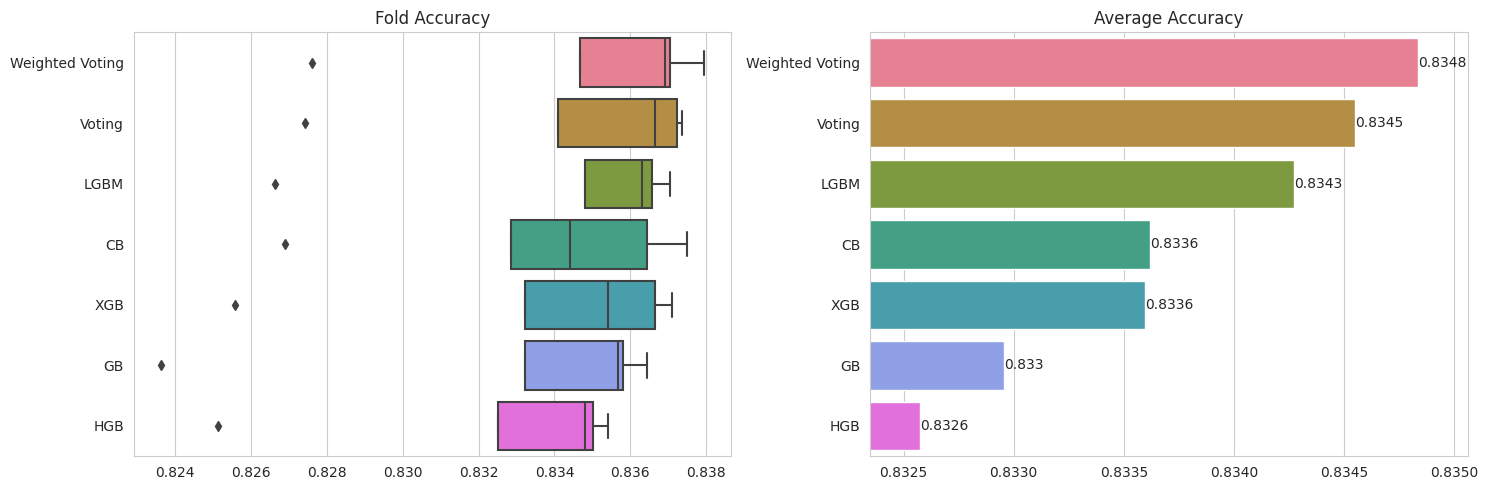

In [21]:
mean_accs = accuracies.mean().sort_values(ascending=False)
order = accuracies.mean().sort_values(ascending=False).index.tolist()

min_acc = mean_accs.min()
max_acc = mean_accs.max()
padding = (max_acc - min_acc) * 0.1
lower_limit = min_acc - padding
upper_limit = max_acc + padding

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

sns.boxplot(data=accuracies, order=order, ax=axs[0], palette='husl', orient='h')
axs[0].set_title('Fold Accuracy')
axs[0].set_xlabel('')
axs[0].set_ylabel('')

barplot = sns.barplot(x=mean_accs.values, y=mean_accs.index, ax=axs[1], palette='husl')
axs[1].set_title('Average Accuracy')
axs[1].set_xlabel('')
axs[1].set_xlim(left=lower_limit, right=upper_limit)
axs[1].set_ylabel('')

for i, score in enumerate(mean_accs.values):
    barplot.text(score, i, round(score, 4), va='center')

plt.tight_layout()
plt.show()

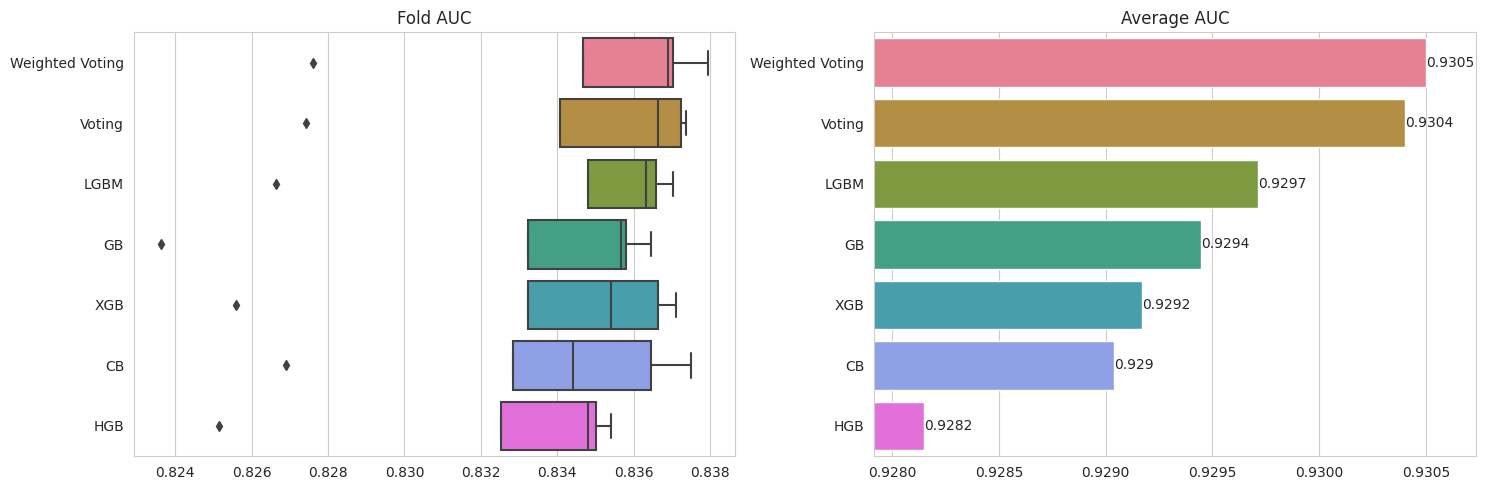

In [22]:
mean_aucs = aucs.mean().sort_values(ascending=False)
order = aucs.mean().sort_values(ascending=False).index.tolist()

min_auc = mean_aucs.min()
max_auc = mean_aucs.max()
padding = (max_auc - min_auc) * 0.1
lower_limit = min_auc - padding
upper_limit = max_auc + padding

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

sns.boxplot(data=accuracies, order=order, ax=axs[0], palette='husl', orient='h')
axs[0].set_title('Fold AUC')
axs[0].set_xlabel('')
axs[0].set_ylabel('')

barplot = sns.barplot(x=mean_aucs.values, y=mean_aucs.index, ax=axs[1], palette='husl')
axs[1].set_title('Average AUC')
axs[1].set_xlabel('')
axs[1].set_xlim(left=lower_limit, right=upper_limit)
axs[1].set_ylabel('')

for i, score in enumerate(mean_aucs.values):
    barplot.text(score, i, round(score, 4), va='center')

plt.tight_layout()
plt.show()

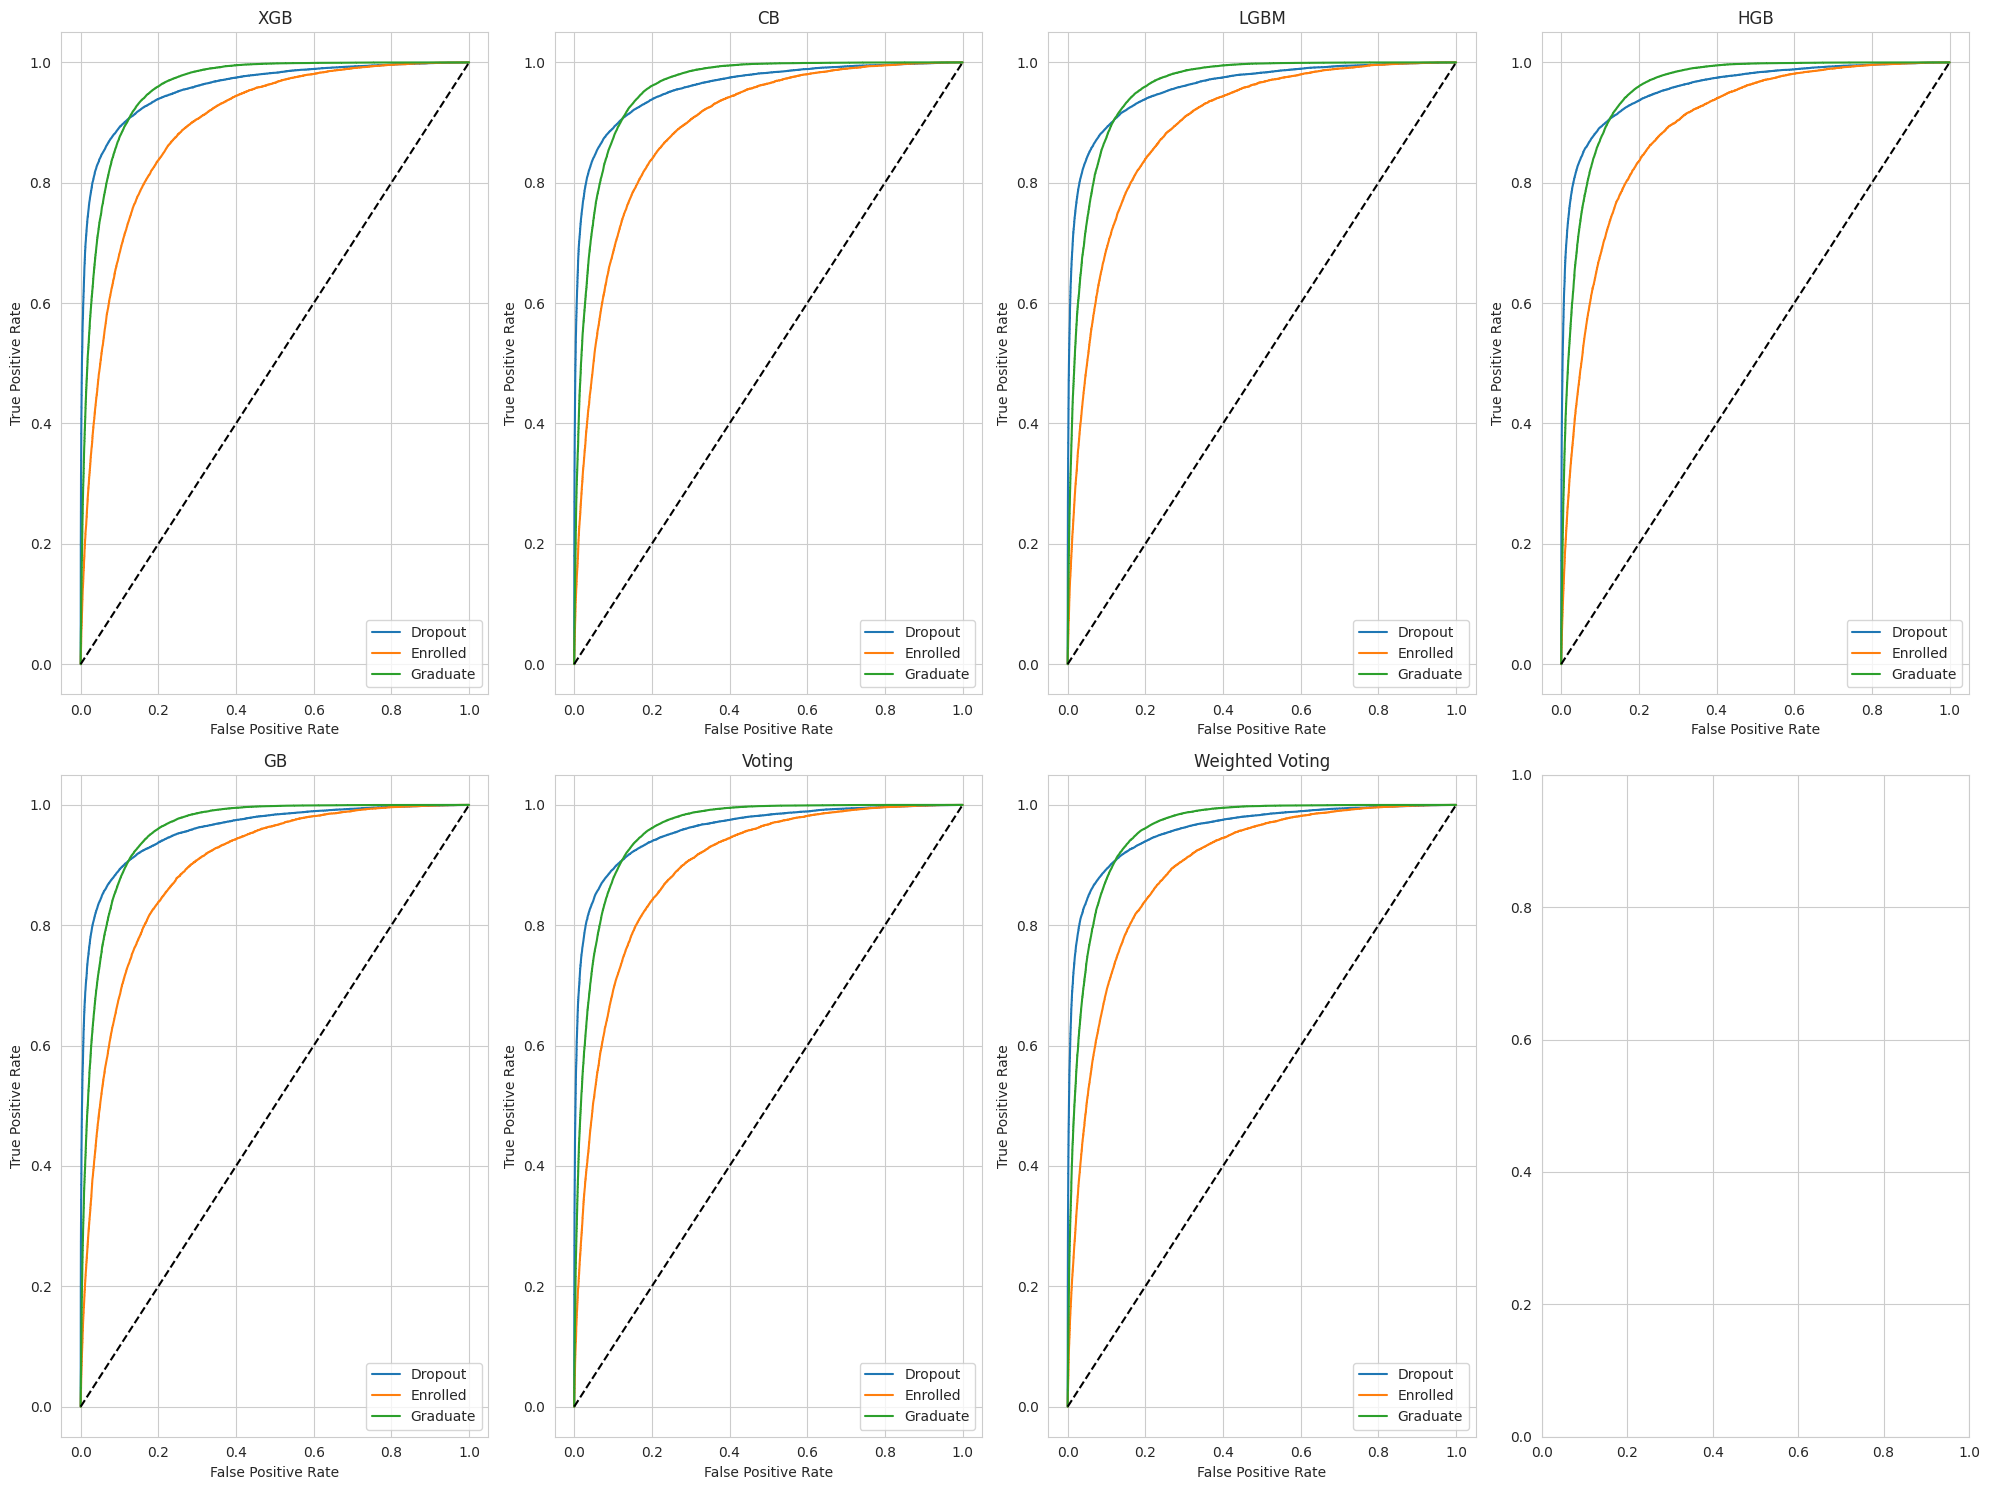

In [23]:
fig, axs = plt.subplots(2, 4, figsize=(20, 15))

for ax, (model, pred_probs) in zip(axs.flatten(), oof_pred_probs.items()):
    for i in range(pred_probs.shape[1]):
        fpr, tpr, _ = roc_curve(y, pred_probs[:, i], pos_label=i)
        ax.plot(fpr, tpr, label=f'{label_encoder.inverse_transform([i])[0]}')

    ax.plot([0, 1], [0, 1], color='black', linestyle='--')
    ax.set_title(model)
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend()

plt.tight_layout()
plt.show()

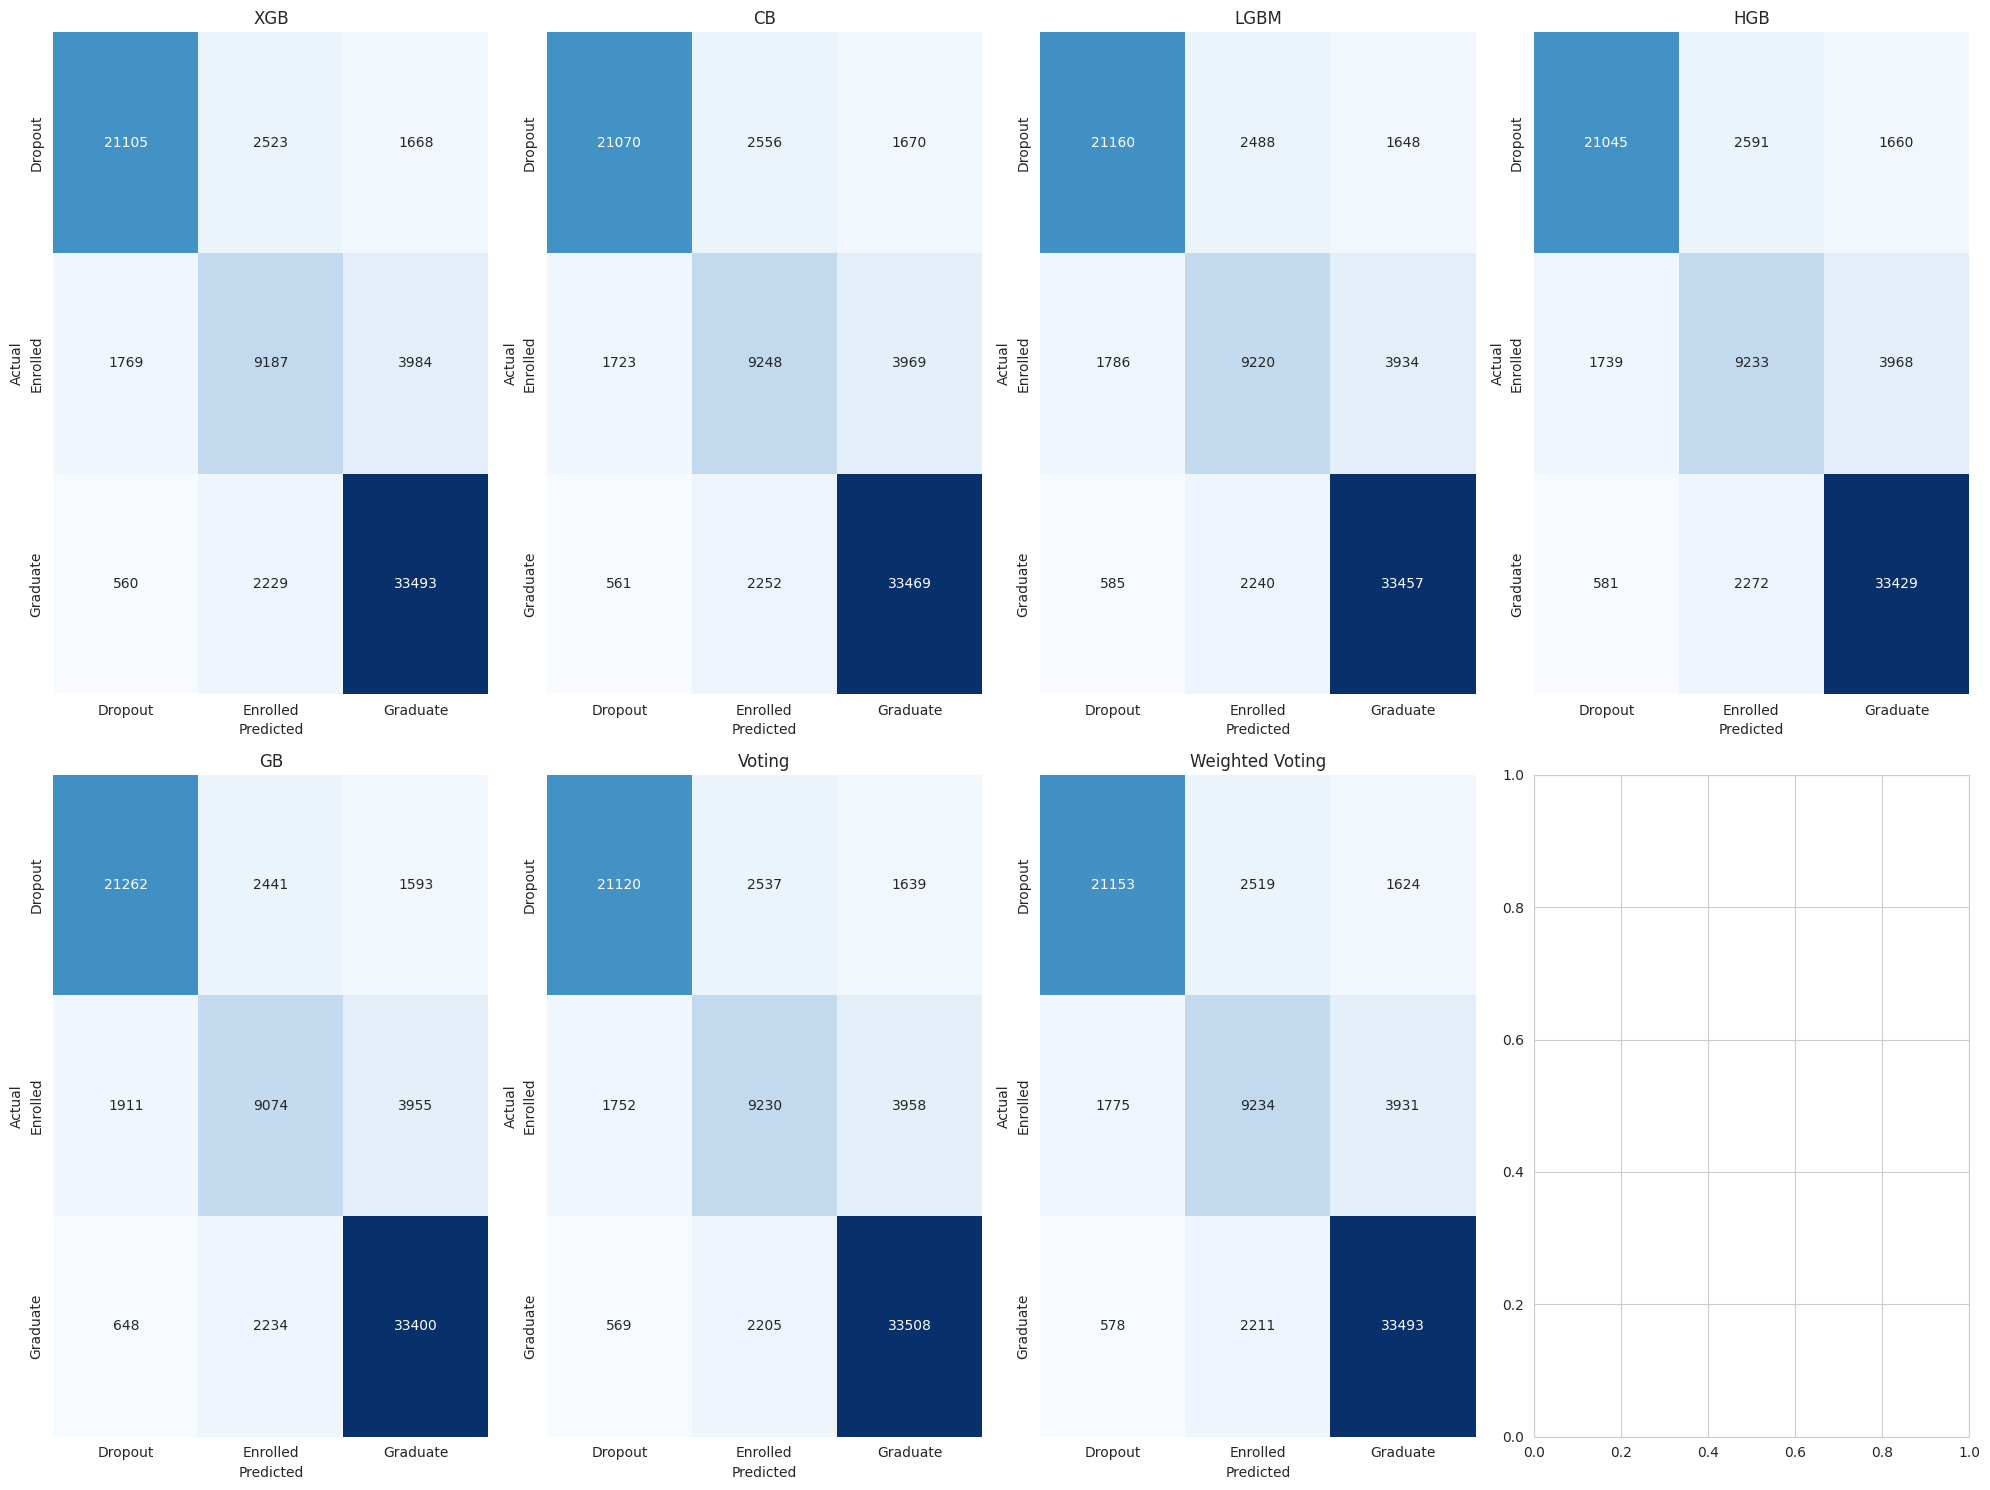

In [24]:
fig, axs = plt.subplots(2, 4, figsize=(20, 15))

for ax, (model, pred_probs) in zip(axs.flatten(), oof_pred_probs.items()):
    y_pred = np.argmax(pred_probs, axis=1)
    cm = confusion_matrix(y, y_pred)
    sns.heatmap(
        cm,
        annot=True,
        cmap='Blues',
        ax=ax,
        xticklabels=label_encoder.classes_,
        yticklabels=label_encoder.classes_,
        cbar=False,
        fmt='d'
    )
    ax.set_title(model)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

plt.tight_layout()
plt.show()

# Post-Processing and Creating a Submission File

In [25]:
submission = pd.read_csv('/kaggle/input/playground-series-s4e6/sample_submission.csv')
submission['Target'] = np.argmax(test_pred_probs['Voting'], axis=1)
submission['Target'] = label_encoder.inverse_transform(submission['Target'])
submission.to_csv(f'voting_acc-{mean_accs["Voting"]:.6f}_auc-{mean_aucs["Voting"]:.6f}.csv', index=False)

In [26]:
submission = pd.read_csv('/kaggle/input/playground-series-s4e6/sample_submission.csv')
submission['Target'] = np.argmax(test_pred_probs['Weighted Voting'], axis=1)
submission['Target'] = label_encoder.inverse_transform(submission['Target'])
submission.to_csv(f'weighted_voting_acc-{mean_accs["Weighted Voting"]:.6f}_auc-{mean_aucs["Weighted Voting"]:.6f}.csv', index=False)

In [27]:
os.mkdir('oof_pred_probs')
os.mkdir('test_pred_probs')

for model, pred_probs in oof_pred_probs.items():
    with open(f'oof_pred_probs/{model.lower().replace(" ", "")}_oof_pred_probs.pkl', 'wb') as f:
        pickle.dump(pred_probs, f)
        
for model, pred_probs in test_pred_probs.items():
    with open(f'test_pred_probs/{model.lower().replace(" ", "")}_test_pred_probs.pkl', 'wb') as f:
        pickle.dump(pred_probs, f)

In [28]:
shutil.rmtree('catboost_info')